In [3]:
# Imports and configs
import os
import requests
import pandas as pd
import base64
import openai
import random

from io import BytesIO
from PIL import Image as PILImage
from IPython.display import display, Image

classify_url = os.getenv("CLASSIFY_URL")
if not classify_url:
    raise ValueError("CLASSIFY_URL environment variable must be set to the API endpoint")

openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY environment variable must be set to the OpenAI API key")

openai.api_key = openai_api_key


In [4]:
# All known cards
label_list = [
 'ace ♣️',
 'ace ♦️',
 'ace ♥️',
 'ace ♠️',
 'eight ♣️',
 'eight ♦️',
 'eight ♥️',
 'eight ♠️',
 'five ♣️',
 'five ♦️',
 'five ♥️',
 'five ♠️',
 'four ♣️',
 'four ♦️',
 'four ♥️',
 'four ♠️',
 'jack ♣️',
 'jack ♦️',
 'jack ♥️',
 'jack ♠️',
 'wild card',
 'king ♣️',
 'king ♦️',
 'king ♥️',
 'king ♠️',
 'nine ♣️',
 'nine ♦️',
 'nine ♥️',
 'nine ♠️',
 'queen ♣️',
 'queen ♦️',
 'queen ♥️',
 'queen ♠️',
 'seven ♣️',
 'seven ♦️',
 'seven ♥️',
 'seven ♠️',
 'six ♣️',
 'six ♦️',
 'six ♥️',
 'six ♠️',
 'ten ♣️',
 'ten ♦️',
 'ten ♥️',
 'ten ♠️',
 'three ♣️',
 'three ♦️',
 'three ♥️',
 'three ♠️',
 'two ♣️',
 'two ♦️',
 'two ♥️',
 'two ♠️'
]
value_map = {
    'ace':   'A',
    'two':   '2',
    'three': '3',
    'four':  '4',
    'five':  '5',
    'six':   '6',
    'seven': '7',
    'eight': '8',
    'nine':  '9',
    'ten':  '10',
    'jack':  'J',
    'queen': 'Q',
    'king':  'K',
    'wild':  'JOKER'
}

In [5]:
# Create a random face card using DALL-E
def generate_card_bytes(card_label:str, size: str = "1024x1024") -> bytes:
    card_name = card_label.split(' ')[0]
    card_value = value_map[card_name]
    card_suit = card_label.split(' ')[1]

    # Determine pip color based on suit
    pip_color = "red" if card_suit in ["♥️", "♦️"] else "black"
    if card_value == 'JOKER':
        pip_color = random.choice(['red', 'black'])

    pip_placement_rules = ""
    if card_value in ["2", "3", "4", "5", "6", "7", "8", "9", "10"]:
        pip_placement_rules += f"- **Central Pips:** For the '{card_value}' card, display exactly {card_value} pips of the '{card_suit}' suit. The pips must be {pip_color}. The pips should have a minimalist, clear, and slightly stylized appearance, similar to classic playing cards."
        if card_value == "2":
            pip_placement_rules += " Place the two pips vertically centered, one near the top and one near the bottom of the central card area, with a clear blank space in the middle."
        elif card_value == "3":
            pip_placement_rules += " Place three pips vertically centered: one at the top, one in the middle, and one at the bottom of the central card area."
        elif card_value == "4":
            pip_placement_rules += " Place four pips in the four corners of the central area, forming a rectangle."
        elif card_value == "5":
            pip_placement_rules += " Place five pips: one in each of the four corners, and one in the exact center of the central card area."
        elif card_value == "6":
            pip_placement_rules += " Place six pips in two vertical rows of three, creating a rectangular pattern."
        elif card_value == "7":
            pip_placement_rules += " Place seven pips: six in two vertical rows of three, and one additional pip centrally above the middle of those two rows."
        elif card_value == "8":
            pip_placement_rules += " Place eight pips: two vertical rows of three on the sides, and two additional pips centrally placed between those rows, one above and one below the center."
        elif card_value == "9":
            pip_placement_rules += " Place nine pips in three vertical rows of three, filling the central area."
        elif card_value == "10":
            pip_placement_rules += " Place ten pips: two vertical rows of three on the sides, and four additional pips in two vertical rows of two in the center."
        pip_placement_rules += f"  No other symbols should appear other than the suit pips.  Exactly {card_value} pips should be displayed.  The background of the card behind the pips should be blank.  All pips should be the same size."
    elif card_value == "A":
        pip_placement_rules += f"- **Central Pips:** Display one large, prominent pip of the '{card_suit}' suit in the exact center of the card. The pip must be {pip_color}. It should have a minimalist, clear, and slightly stylized appearance, similar to classic playing cards."
    elif card_value in ["J", "Q", "K"]:
        pip_placement_rules += f"- **Central Illustration:** A clear illustration depicting the corresponding '{card_name}' figure. The style should be consistent with a playing card, possibly with a 'two-way' (mirrored/inverted) design."
    elif card_value == "JOKER":
        pip_placement_rules += "- **Central Illustration:** A distinct, stylized illustration of a Joker figure. This card typically does not have a suit."
    
    rules_string = f"""
Generate an image of a {card_label} playing card. Adhere strictly to the following rules for its design:

**I. Core Card Attributes:**
- **Card Value/Rank:** Must be '{card_value}' displayed clearly in the top-left and bottom-right corners, easily legible.  The '{card_value}' should be displayed upside down in the bottom-right corner.
- **Card Suit:** Must be '{card_suit}' prominently positioned with the value in the top-left and bottom-right corners. This suit must be {pip_color}.  The '{card_suit}' should be displayed upside down in the bottom-right corner.
{pip_placement_rules}

**II. Aesthetic and Compositional Rules:**
- **Orientation:** Portrait orientation (taller than wide).
- **Borders:** A thin, consistent border framing the card face.
- **Color Palette:** Hearts and Diamonds must be red. Clubs and Spades must be black. Ensure high contrast for readability.
- **Stylization:** The card should have a traditional, clean playing card aesthetic.
- **Symmetry:** The King, Queen, and Jack figures should have a "two-way" (mirrored/inverted) design for readability from both ends.
- **Background:** The card face should have a light, off-white background.

**III. Constraints:**
- Do not obscure the value, suit, or central illustration.
- Only display the suit that was requested.
- Do not add misleading elements that could be mistaken for a different value, suit, or type of card.
- Avoid misleading elements or excessive clutter.
- Avoid overly busy designs that hinder readability.
- No inappropriate content.
- No arbitrary text on the card face beyond the card value/rank.
- Display one, single card.
"""
    prompt = rules_string
    print('Using prompt:\n', prompt)

    resp = openai.images.generate(
        model="dall-e-3",
        prompt=prompt, 
        n=1, 
        size=size
    )
    url  = resp.data[0].url
    img_resp = requests.get(url)
    img_resp.raise_for_status()
    return img_resp.content

In [6]:
# Create a random face card using DALL-E
def generate_card_bytes(card_label:str, size: str = "1024x1024") -> bytes:
    card_name = card_label.split(' ')[0]
    card_value = value_map[card_name]
    card_suit = card_label.split(' ')[1]

    # Determine pip color based on suit
    pip_color = "red" if card_suit in ["♥️", "♦️"] else "black"
    if card_value == 'JOKER':
        pip_color = random.choice(['red', 'black'])

    pip_placement_rules = ""
    if card_value in ["2", "3", "4", "5", "6", "7", "8", "9", "10"]:
        pip_placement_rules += f"- **Central Pips:** For the '{card_value}' card, display exactly {card_value} pips of the '{card_suit}' suit. The pips must be {pip_color}. The pips should have a minimalist, clear, and slightly stylized appearance, similar to classic playing cards."
        if card_value == "2":
            pip_placement_rules += " Place the two pips vertically centered, one near the top and one near the bottom of the central card area, with a clear blank space in the middle."
        elif card_value == "3":
            pip_placement_rules += " Consider a card to be 25x35,  Place the pips at (12.5, 7.5), (12.5, 17.5), and (12.5, 27.5). The (12.5, 27.5) pip should be displayed upside down."
        elif card_value == "4":
            pip_placement_rules += " Place four pips in the four corners of the central area, forming a rectangle."
        elif card_value == "5":
            pip_placement_rules += " Place five pips: one in each of the four corners, and one in the exact center of the central card area."
        elif card_value == "6":
            pip_placement_rules += " Place six pips in two vertical rows of three, creating a rectangular pattern."
        elif card_value == "7":
            pip_placement_rules += " Place seven pips: six in two vertical rows of three, and one additional pip centrally above the middle of those two rows."
        elif card_value == "8":
            pip_placement_rules += " Place eight pips: two vertical rows of three on the sides, and two additional pips centrally placed between those rows, one above and one below the center."
        elif card_value == "9":
            pip_placement_rules += " Place nine pips in three vertical rows of three, filling the central area."
        elif card_value == "10":
            pip_placement_rules += " Place ten pips: two vertical rows of three on the sides, and four additional pips in two vertical rows of two in the center."
        pip_placement_rules += f"  No other symbols should appear other than the suit pips.  Exactly {card_value} pips should be displayed.  The background of the card behind the pips should be blank.  All pips should be the same size."
    elif card_value == "A":
        pip_placement_rules += f"- **Central Pips:** Display one large, prominent pip of the '{card_suit}' suit in the exact center of the card. The pip must be {pip_color}. It should have a minimalist, clear, and slightly stylized appearance, similar to classic playing cards."
    elif card_value in ["J", "Q", "K"]:
        pip_placement_rules += f"- **Central Illustration:** A clear illustration depicting the corresponding '{card_name}' figure. The style should be consistent with a playing card, possibly with a 'two-way' (mirrored/inverted) design."
    elif card_value == "JOKER":
        pip_placement_rules += "- **Central Illustration:** A distinct, stylized illustration of a Joker figure. This card typically does not have a suit."
    
    rules_string = f"""
Generate an image of a {card_label} playing card. Adhere strictly to the following rules for its design:

**I. Core Card Attributes:**
- **Card Value/Rank:** Must be '{card_value}' displayed clearly in the top-left and bottom-right corners, easily legible.  The '{card_value}' should be displayed upside down in the bottom-right corner.
- **Card Suit:** Must be '{card_suit}' prominently positioned with the value in the top-left and bottom-right corners. This suit must be {pip_color}.  The '{card_suit}' should be displayed upside down in the bottom-right corner.
{pip_placement_rules}

**II. Aesthetic and Compositional Rules:**
- **Orientation:** Portrait orientation (taller than wide).
- **Borders:** A thin, consistent border framing the card face.
- **Color Palette:** Hearts and Diamonds must be red. Clubs and Spades must be black. Ensure high contrast for readability.
- **Stylization:** The card should have a traditional, clean playing card aesthetic.
- **Symmetry:** The King, Queen, and Jack figures should have a "two-way" (mirrored/inverted) design for readability from both ends.
- **Background:** The card face should have a light, off-white background.

**III. Constraints:**
- Do not obscure the value, suit, or central illustration.
- Only display the suit that was requested.
- Do not add misleading elements that could be mistaken for a different value, suit, or type of card.
- Avoid misleading elements or excessive clutter.
- Avoid overly busy designs that hinder readability.
- No inappropriate content.
- No arbitrary text on the card face beyond the card value/rank.
- Display one, single card.
"""
    prompt = rules_string
    print('Using prompt:\n', prompt)

    resp = openai.images.generate(
        model="dall-e-3",
        prompt=prompt, 
        n=1, 
        size=size
    )
    url  = resp.data[0].url
    img_resp = requests.get(url)
    img_resp.raise_for_status()
    return img_resp.content

In [10]:
# Create a random card using DALL·E
def generate_card_bytes(card_label: str, size: str = "1024x1024") -> bytes:
    card_name, card_suit = card_label.split(" ")
    card_value = value_map[card_name]
    is_face = card_value in ("J","Q","K")
    is_ace  = card_value == "A"
    is_num  = card_value.isdigit()

    # Simplify to a single, focused prompt:
    prompt = f"""
    A high-resolution, photorealistic scan of a single playing card: the {card_label}, 
    in the exact style of the standard Bicycle deck.
    
    • Card face: off-white background, thin black border, portrait orientation.  
    • Corners: Top-left and bottom-right show “{card_value}” and a small {card_suit} pip (bottom one inverted).  
    • Center pips: {"one large" if is_ace else "exactly three"} identical {card_suit} symbol{" (all upright)" if is_num else ""}, 
      arranged vertically—one at the top center of the face, one at the exact center, one at the bottom center.  
      No other pip shapes or decorations.  
    • Face-cards: a two-way mirrored illustration of the {card_name}, in classic playing-card style (no extra flourishes).  
    • No spandrels, filigree, logos, or decorative corners—just the card face, exactly as in a standard deck.
    """

    print("Using prompt:\n", prompt)
    resp = openai.images.generate(
        model="dall-e-3",
        prompt=prompt,
        n=1,
        size=size
    )
    url = resp.data[0].url
    img_resp = requests.get(url)
    img_resp.raise_for_status()
    return img_resp.content


In [12]:
def generate_card_bytes(card_label: str, size: str = "1024x1024") -> bytes:
    # we know card_label == "three clubs" here
    prompt = """
Create a flat, high‑resolution vector graphic of a single playing card: the 3 of Clubs.

– Card shape: a portrait‑oriented rectangle (ratio ~2.5:3.5) on a solid off‑white background with a thin black border.  
– Corner indices: top‑left and bottom‑right show the digit “3” in a clean sans‑serif font plus a small solid black club (♣).  
  The bottom‑right index and suit must be inverted (upside‑down).  
– Center pips: exactly three identical solid black club symbols (♣), uniform in size (≈10% of card width).  
  Place them vertically at 25%, 50% and 75% of the card’s height, all upright, dead‑center horizontally.  
– No other symbols, textures, filigree, shadows, flourishes, or background patterns—just the card face.  
"""
    print("Using prompt:\n", prompt)
    resp = openai.images.generate(
        model="dall-e-3",
        prompt=prompt,
        n=1,
        size=size
    )
    img_data = requests.get(resp.data[0].url).content
    return img_data


In [16]:
def generate_card_bytes(card_label:str, size: str = "1024x1024") -> bytes:
    card_name = card_label.split(' ')[0]
    card_value = value_map[card_name]
    card_suit = card_label.split(' ')[1]

    # Determine pip color based on suit
    pip_color = "red" if card_suit in ["♥️", "♦️"] else "black"
    if card_value == 'JOKER':
        pip_color = random.choice(['red', 'black'])

    pip_placement_rules = ""
    if card_value in ["2", "3", "4", "5", "6", "7", "8", "9", "10"]:
        pip_placement_rules += f"- **Central Pips:** Display exactly {card_value} pips of the '{card_suit}' suit. The pips must be {pip_color}. The pips should be all the same size, minimalist, clear, and slightly stylized, similar to classic playing cards. All pips should be oriented correctly (not upside down). "
        if card_value == "2":
            pip_placement_rules += "Place the two pips vertically, one centered near the top and one centered near the bottom of the central card area, with clear space in between."
        elif card_value == "3":
            pip_placement_rules += "Place three pips in a vertical column, centered on the card: one near the top, one in the middle, and one near the bottom. All pips should be correctly oriented."
        elif card_value == "4":
            pip_placement_rules += "Place four pips in the four corners of the central area, forming a perfect rectangle."
        elif card_value == "5":
            pip_placement_rules += "Place five pips: one in each of the four corners of the central area, and one in the exact center."
        elif card_value == "6":
            pip_placement_rules += "Place six pips in two vertical rows of three, creating a rectangular pattern."
        elif card_value == "7":
            pip_placement_rules += "Place seven pips: six in two vertical rows of three, and one additional pip centrally positioned above the middle of those two rows."
        elif card_value == "8":
            pip_placement_rules += "Place eight pips: two vertical rows of three on the sides, and two additional pips centrally placed between those rows, one above and one below the center."
        elif card_value == "9":
            pip_placement_rules += "Place nine pips in three distinct vertical rows of three, filling the central area evenly."
        elif card_value == "10":
            pip_placement_rules += "Place ten pips: two vertical rows of three on the sides, and four additional pips forming two vertical rows of two in the center."
        pip_placement_rules += f" No other symbols or small pips should appear in the central area, only the exactly {card_value} main pips. The background of the card behind the pips should be blank and light off-white."
    elif card_value == "A":
        pip_placement_rules += f"- **Central Pips:** Display one large, prominent pip of the '{card_suit}' suit in the exact center of the card. The pip must be {pip_color}. It should have a minimalist, clear, and slightly stylized appearance, similar to classic playing cards."
    elif card_value in ["J", "Q", "K"]:
        pip_placement_rules += f"- **Central Illustration:** A clear illustration depicting the corresponding '{card_name}' figure. The style should be consistent with a traditional playing card, with a 'two-way' (mirrored/inverted) design where the top and bottom halves are symmetrical."
    elif card_value == "JOKER":
        pip_placement_rules += "- **Central Illustration:** A distinct, stylized illustration of a Joker figure. This card typically does not have a suit displayed in the central area."
    
    rules_string = f"""
Generate a realistic image of a {card_label} playing card, adhering strictly to the following rules for its design:

**I. Core Card Attributes:**
- **Card Value/Rank:** Must be '{card_value}' displayed clearly in the top-left corner. The exact same '{card_value}' must also be displayed in the bottom-right corner, but it must be upside down.
- **Card Suit:** The symbol for '{card_suit}' must be prominently positioned next to the value in the top-left corner. The exact same '{card_suit}' symbol must also be displayed next to the upside-down value in the bottom-right corner, but it must be upside down. This suit symbol must be {pip_color}.
{pip_placement_rules}

**II. Aesthetic and Compositional Rules:**
- **Orientation:** The card must be in portrait orientation (taller than wide).
- **Borders:** Include a thin, consistent border framing the entire card face.
- **Color Palette:** All Hearts (♥️) and Diamonds (♦️) elements (including pips and corner symbols) must be red. All Clubs (♣️) and Spades (♠️) elements must be black. Ensure high contrast for excellent readability.
- **Stylization:** The card should have a traditional, clean, and classic playing card aesthetic, resembling standard poker or bridge decks.
- **Symmetry:** For Jack, Queen, and King cards, the central illustration should have a "two-way" (mirrored/inverted) design, meaning the top half is a mirror image of the bottom half, allowing the card to be read from either end.
- **Background:** The main face of the card, behind all pips and illustrations, should be a consistent light, off-white, or cream color.

**III. Constraints and Exclusions:**
- Do not obscure any part of the card's value, suit, or central illustration.
- Only display the specified suit '{card_suit}'. Do not introduce other suit symbols.
- Do not add any misleading elements, extra pips, or arbitrary text on the card face beyond the card value/rank and the specified number of central pips.
- Avoid overly busy designs or excessive clutter that would hinder readability.
- No inappropriate or offensive content.
- Ensure that the central pips are the only pips present in the main body of the card, distinct from the corner indicators.
- Display one, single card clearly.
"""
    prompt = rules_string
    print('Using prompt:\n', prompt)
    
    resp = openai.images.generate(
        model="dall-e-3",
        prompt=prompt,
        n=1,
        size=size
    )
    img_data = requests.get(resp.data[0].url).content
    return img_data
    

Working on generating a  three ♣️
Using prompt:
 
Generate a realistic image of a three ♣️ playing card, adhering strictly to the following rules for its design:

**I. Core Card Attributes:**
- **Card Value/Rank:** Must be '3' displayed clearly in the top-left corner. The exact same '3' must also be displayed in the bottom-right corner, but it must be upside down.
- **Card Suit:** The symbol for '♣️' must be prominently positioned next to the value in the top-left corner. The exact same '♣️' symbol must also be displayed next to the upside-down value in the bottom-right corner, but it must be upside down. This suit symbol must be black.
- **Central Pips:** Display exactly 3 pips of the '♣️' suit. The pips must be black. The pips should be all the same size, minimalist, clear, and slightly stylized, similar to classic playing cards. All pips should be oriented correctly (not upside down). Place three pips in a vertical column, centered on the card: one near the top, one in the middle, a

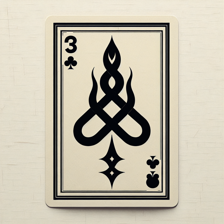

→ STATUS: 200
→ RESPONSE BODY: {"label": "six of diamonds", "confidence": 0.420659453}


In [17]:
# Number of cards to draw/test
NUM_CARDS = 1

# Loop: download + classify
results = []
for _ in range(NUM_CARDS):
    # Get a random card name
    random_card = random.choice(label_list)
    random_card = 'three ♣️'
    print('Working on generating a ', random_card)
    
    # get a card image bytes from Dall-E
    img_bytes = generate_card_bytes(random_card)

    # open & resize to 224×224
    img = PILImage.open(BytesIO(img_bytes)).convert("RGB")
    img = img.resize((224, 224))
    print('Generated image:')
    display(img)
    
    # encode to PNG in-memory, then to base64
    buf = BytesIO()
    img.save(buf, format="PNG")
    img_base64 = base64.b64encode(buf.getvalue()).decode("ascii")

    # send JSON payload
    payload = {"image_base64": img_base64}
    class_resp = requests.post(classify_url, json=payload)
    print("→ STATUS:", class_resp.status_code)
    print("→ RESPONSE BODY:", class_resp.text)
    try:
        class_resp.raise_for_status()
    except requests.HTTPError:
        raise  # re‑raise so you still see the stack trace

    prediction = class_resp.json().get("prediction", class_resp.text)

    # record it
    results.append({
        "card":       random_card,
        "prediction": prediction,
        "image":      img
    })


,card,prediction,image
0,eight ♣️,"{""label"": ""ace of spades"", ""confidence"": 0.959...",<PIL.Image.Image image mode=RGB size=224x224 a...


eight ♣️ → Predicted: {"label": "ace of spades", "confidence": 0.95946312}


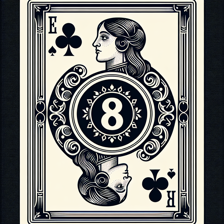

In [14]:
# Display results in a DataFrame + render the images
df = pd.DataFrame(results)
display(df)

# And to actually show each image inline:
for row in results:
    print(f"{row['card']} → Predicted: {row['prediction']}")
    display(row["image"])